In [20]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl
from celegans_connectome_analysis.get_nx import get_adult_c_elegans_nx,get_fxnl_nx

In [21]:
G_stx = get_fxnl_nx()
G_stx = get_adult_c_elegans_nx()

/Users/thomasathey/Documents/shavit-lab/celegans/celegans_connectome_analysis/celegans_connectome_analysis/get_nx.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


# Graspologic plotting

In [22]:
# remove all nodes that have neuron type equal to Muscle\
muscle_nodes = [n for n in G_stx.nodes if G_stx.nodes[n]["neuron type"] == "Muscle"]
G_stx.remove_nodes_from(muscle_nodes)

A = nx.adjacency_matrix(G_stx).todense()
neuron_types = [G_stx.nodes[n]["neuron type"] for n in G_stx.nodes]

# # permmute A and neuron_types so Mod. neurons come before Motor neurons
# perm = [i for i in range(len(neuron_types)) if neuron_types[i] != "Mod."]
# perm += [i for i in range(len(neuron_types)) if neuron_types[i] == "Mod."]
# A = A[perm,:][:,perm]
# neuron_types = [neuron_types[i] for i in perm]


## Compute average weights between communities

In [23]:
# for every combination of neuron types, get the number of edges between them
edges = []
for i in range(len(neuron_types)):
    for j in range(len(neuron_types)):
        if i != j:
            edges.append((neuron_types[i], neuron_types[j], A[i,j]))
edges = pd.DataFrame(edges, columns=["source", "target", "weight"])

# get the number of edges between each neuron type
edges = edges.groupby(["source", "target"]).mean().reset_index()

edges

,source,target,weight
0,Inter.,Inter.,0.603594
1,Inter.,Mod.,0.124608
2,Inter.,Mot.,0.389610
3,Inter.,Other,0.030303
4,Inter.,Sens.,0.104895
5,Mod.,Inter.,0.357367
6,Mod.,Mod.,0.220443
7,Mod.,Mot.,0.212644
8,Mod.,Other,0.080460
9,Mod.,Sens.,0.125199


## Check that adjacency is structured pre->post

In [24]:
# get the first edge
edges = list(G_stx.edges(data=True))
edge = edges[0]

# get the node indices of the edge
pre = list(G_stx.nodes).index(edge[0])
post = list(G_stx.nodes).index(edge[1])

# double check that A[pre, post] is the same as edge[2]["weight"]
assert A[pre, post] == edge[2]["weight"]

## Plot

<Axes: title={'center': 'Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)'}>

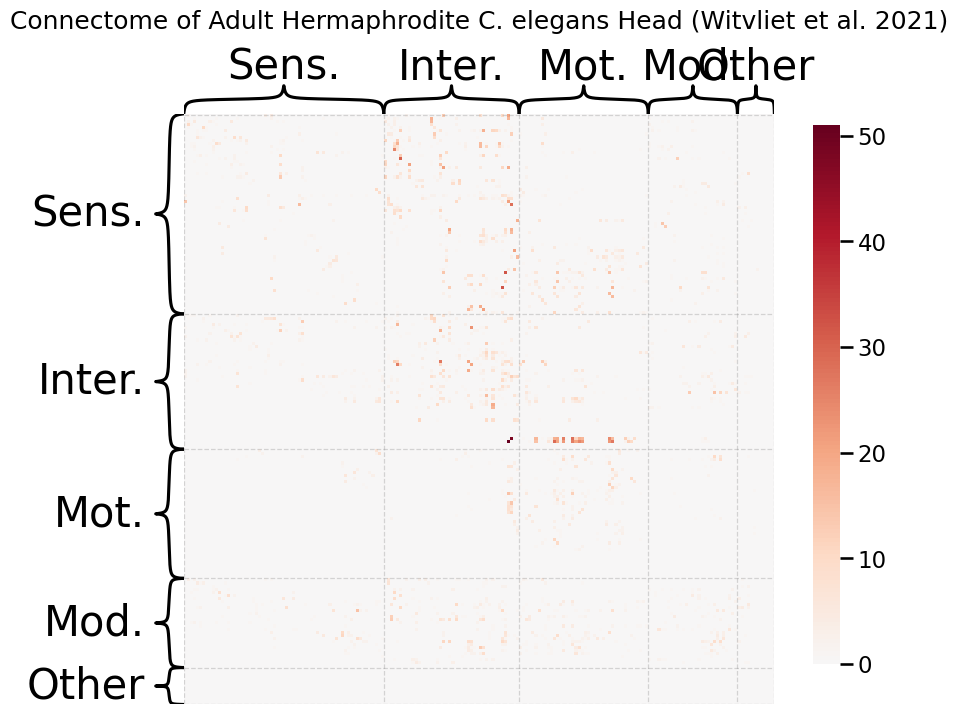

In [25]:
# use gl.plot.heatmap to plot the adjacency matrix and make the figure size 20x20
#fig, ax = plt.subplots(figsize=(20, 20))


title = "Connectome of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)"

gl.plot.heatmap(A, inner_hier_labels=neuron_types, sort_nodes=False, title=title)#, ax=ax)



<Axes: title={'center': 'Binarized of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)'}>

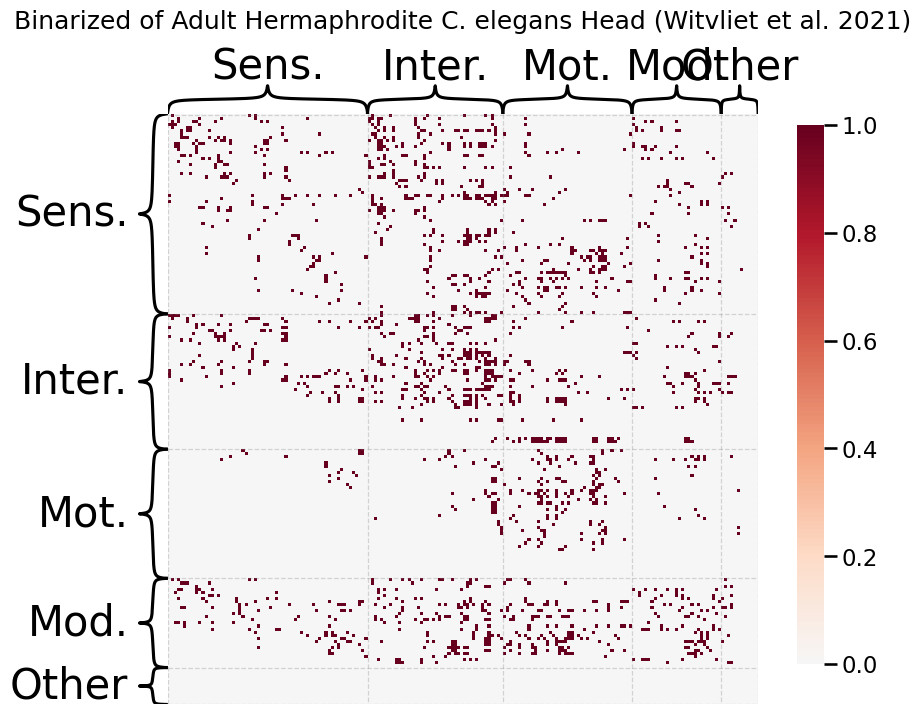

In [26]:
# use gl.plot.heatmap to plot the adjacency matrix and make the figure size 20x20
#fig, ax = plt.subplots(figsize=(20, 20))


title = "Binarized of Adult Hermaphrodite C. elegans Head (Witvliet et al. 2021)"

gl.plot.heatmap(A>0, inner_hier_labels=neuron_types, sort_nodes=False, title=title)#, ax=ax)

